This notebook is mainly responsible for creating benchmarks models to compare against, including RGM (Random Guess Model), PPM (Prior Probabilistic Model), and CPPM (Constrained Prior Probabilistic Model).

# Imports and Setups

In [1]:
# Data preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys, os, json, pickle, time
import re
import string
import random
import functools, itertools, operator
import concurrent.futures
import requests
from io import BytesIO
from PIL import Image
from tqdm.notebook import tqdm as tqdm_nb
from tqdm import tqdm
from collections import namedtuple
from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE

# Sklearn
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Deep Learning
from transformers import BertTokenizer, BertModel
import torchvision.transforms as transforms
import torchvision.models as models
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_, clip_grad_value_
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter


# Notebook Setups
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, HTML
InteractiveShell.ast_node_interactivity = "all"
sns.set()

pd.set_option('display.max_columns', None)


# Helper functions
def print_colored_text(text, background_color="white", font_color="black", bold=False):
    font_weight = "bold" if bold else "normal"
    html_code = f'<div style="background-color: {background_color}; color: {font_color}; font-weight: {font_weight}; padding: 10px; display: inline-block;">{text}</div>'
    display(HTML(html_code))

In [2]:
# Read in Data
channel_videos = pd.read_pickle(os.path.join("dataframes", "channel_videos.pkl"))
LABEL = "feat_video_label_40"

In [3]:
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [4]:
# Fix random seed
def set_seed(seed: int=SEED) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    return None

set_seed()

__Model Source: [Chinese RoBERTa GitHub](https://github.com/ymcui/Chinese-BERT-wwm)__

In [5]:
# Load the pretrained BERT model and tokenizer
model_name = "hfl/chinese-roberta-wwm-ext"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

resnet = models.resnet50(pretrained=True).to(DEVICE)

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/francia/anaconda3/envs/chris_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is d

# Preprocess data
## Preprocess channel data 

In [6]:
# Channel Features
channel_text_features = ["channel_title", "channel_description", "channel_keywords"]
channel_image_features = ["channel_thumbnail_high_url", "channel_banner_url"]
channel_cat_features = ["channel_topic_categories"]
channel_statistics_features = ["channel_view_count", "channel_subscriber_count", "channel_video_count"]
channel_datetime_features = ["channel_published_at"]
eps = 1e-7

In [7]:
channel_videos["channel_country"] = channel_videos.channel_country.fillna("TW").value_counts(dropna=False)

In [8]:
def preprocess_image_from_url(url):
    # Get Image from url
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception if the request was unsuccessful
    except Exception: #  (requests.exceptions.RequestException, IOError) URL is broken or image couldn't be accessed
        # Return zero-padded tensors as placeholders
        return torch.zeros((3, 224, 224), dtype=torch.float32)
    # Preprocess Image
    image = Image.open(BytesIO(response.content)).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    preprocessed_image = transform(image)
    return preprocessed_image

def encode_images(column, chunk_num=0, max_workers=10):

    encoded_images = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        submit_pbar = tqdm_nb(column, desc=f"Submit_{chunk_num:02}", colour='green')
        result_image_futures = [executor.submit(preprocess_image_from_url, url) for url in submit_pbar]

        image_pbar = tqdm_nb(result_image_futures, desc=f"Image_{chunk_num:02} ", colour='#5FDD9D')
        for i, image in enumerate(image_pbar):
            image = image.result().to(DEVICE)
            image = image.unsqueeze(0) # create a mini-batch as expected by the model
            with torch.no_grad():
                features = resnet(image)
            encoded_images.append(features.squeeze(0).cpu().numpy())
        
    return torch.tensor(np.array(encoded_images))

def encode_images_by_chunks(column, save_path, chunksize=10_000):
    n_splits = len(column) // chunksize
    chunks = np.array_split(column, n_splits)
    chunk_pbar = tqdm_nb(chunks, total=len(chunks), position=0, colour='red')
    for i, chunk in enumerate(chunk_pbar):
        chunk_pbar.set_description(f"Chunk_{i:02}")
        save_path = save_path[:-3] if save_path.endswith(".pt") else save_path
        save_path_with_index = f"{save_path}_{i}.pt"
        if os.path.exists(save_path_with_index): # Skipped encoded images
            time.sleep(0.1)
            continue
        image_tensor = encode_images(chunk, chunk_num=i) # download and encode images in multithreads
        torch.save(image_tensor, save_path_with_index)

In [9]:
def plot_original_and_preprocessed_image(sample_url):
    
    image = Image.open(BytesIO(requests.get(sample_url).content)).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    preprocessed_image = transform(image)

    display(image)

    plt.figure()
    plt.imshow(preprocessed_image.permute(1, 2, 0))
    plt.grid(False)
    plt.show();
    
# sample_thumbnail_default_url, sample_thumbnail_high_url, sample_banner_url = channel_videos[["channel_thumbnail_default_url", "channel_thumbnail_high_url", "channel_banner_url"]].sample().values[0]
# plot_original_and_preprocessed_image(sample_thumbnail_default_url)
# plot_original_and_preprocessed_image(sample_thumbnail_high_url)
# plot_original_and_preprocessed_image(sample_banner_url)

In [10]:
def preprocess_channel_data(channel_videos):
    # Join list of texts into a string
    channel_videos["channel_keywords"] = channel_videos["channel_keywords"].str.join(" ")
        
    ########### 1. Preprocess `channel_published_at` (datetime) ###########
    # 1.1 - Extract year, month, day & Take log
    channel_datetime_column = channel_videos[channel_datetime_features[0]]
    channel_date_features = pd.concat((channel_datetime_column.dt.year.rename("channel_published_year"),
                                channel_datetime_column.dt.month.rename("channel_published_month"),
                                channel_datetime_column.dt.day.rename("channel_published_day")), axis=1)
    # 1.2 - Join extracted features back to channel_videos
    channel_videos = pd.concat((channel_videos, channel_date_features), axis=1)
    
    
    ########### 2. Select channel features and get unique data/rows ###########
    channel_features = (["channel_id"] + channel_text_features + channel_image_features + channel_statistics_features
                         + list(channel_date_features.columns) + ["channel_topic_categories"])
    channel_data = channel_videos[channel_features].drop_duplicates(subset="channel_id").reset_index(drop=True)

    
    ########### 3. Take the log of statistics and datetime features ###########
    stats_features = channel_statistics_features + list(channel_date_features.columns)
    channel_stats_feature_tensors = torch.tensor(
                                         (channel_data[stats_features] + eps)
                                         .apply(np.log10).values)
    
    
    ########### 4. Preprocess `channel_topic_categories` (Label-Encoding) ###########
    # 4.1 - Fill missing values as empty lists
    channel_data["channel_topic_categories"] = channel_data["channel_topic_categories"].apply(lambda x: x if x is not None else [])
    # 4.2 - Multilabel "One-Hot-Encoding"
    channel_topic_categories_mlb = MultiLabelBinarizer()
    channel_cat_features_encoded = channel_topic_categories_mlb.fit_transform(channel_data[channel_cat_features[0]])
    # 4.3 - Multilabel "Label-Encoding": Get indices where the entries are 1s for each row
    nonzero_indices_dict = {}
    row_indices, col_indices = np.where(channel_cat_features_encoded == 1)
    for r, c in zip(row_indices, col_indices):
        if r not in nonzero_indices_dict:
            nonzero_indices_dict[r] = [c]
        else:
            nonzero_indices_dict[r].append(c)

    for i in range(len(channel_cat_features_encoded)):
        if i not in nonzero_indices_dict:
            nonzero_indices_dict[i] = []
    # 4.4- Pad features with zeros
    channel_cat_feature_tensors = pad_sequence([torch.tensor(cat_list) + 1 for cat_list in channel_data.index.map(nonzero_indices_dict)], batch_first=True)
    
    
    ########### 5. Preprocess `channel_thumbnail_high_url` & `channel_banner_url` (ResNet) ###########
    channel_thumbnail_image_tensors = encode_images(channel_data["channel_thumbnail_high_url"])  # 166x1000
    channel_banner_image_tensors = encode_images(channel_data["channel_banner_url"])             # 166x1000
    
    channel_images_tensors = torch.cat((channel_thumbnail_image_tensors, channel_banner_image_tensors), dim=1) # 166x2000
    
    return channel_data, channel_stats_feature_tensors.float(), channel_cat_feature_tensors.float(), channel_images_tensors.float()

In [11]:
def encode_channel_text_features(df, save_path):
    BERT_EMBEDDING_SIZE = 768
    title_list = df.channel_title.values.tolist()
    description_list = df.channel_description.values.tolist()
    keywords_list = df.channel_keywords.values.tolist()
    embedding_tensor = torch.ones((len(title_list), BERT_EMBEDDING_SIZE))
    for i in tqdm(range(len(title_list))):
        context = title_list[i] + " [SEP] " + description_list[i] + " [SEP] " + keywords_list[i]
        bert_input = tokenizer(context, padding='max_length', max_length=512, truncation=True, return_tensors="pt")
        attention_mask = bert_input['attention_mask']
        input_id = bert_input['input_ids'].squeeze(1)
        final_inputs = {'input_ids': input_id, 'attention_mask': attention_mask}
        outputs = bert_model(**final_inputs)
        # [CLS]
        pooler_output = outputs.pooler_output.reshape(BERT_EMBEDDING_SIZE).detach().cpu()
        embedding_tensor[i] = pooler_output
    torch.save(embedding_tensor, save_path)
    return embedding_tensor

In [12]:
%%time
# 0) Preprocess channel
channel_data, channel_stats_feature_tensors, channel_cat_feature_tensors, channel_image_tensors = preprocess_channel_data(channel_videos)
# 1) Load the text embeddings for videos
# channel_text_embeddings = encode_channel_text_features(channel_data, "embeddings/channel_text_embeddings.pt")
channel_text_embeddings = torch.load("embeddings/channel_text_embeddings.pt")
# 3) Concat all features
channel_feature_tensors = torch.cat((channel_text_embeddings,
                                     channel_stats_feature_tensors,
                                     channel_cat_feature_tensors,
                                     channel_image_tensors), axis=1).float()

Submit_00:   0%|          | 0/166 [00:00<?, ?it/s]

Image_00 :   0%|          | 0/166 [00:00<?, ?it/s]

Submit_00:   0%|          | 0/166 [00:00<?, ?it/s]

Image_00 :   0%|          | 0/166 [00:00<?, ?it/s]

CPU times: user 33.1 s, sys: 377 ms, total: 33.5 s
Wall time: 4.24 s


In [13]:
# Identify the dimensions of each type of channel data
channel_text_dim = channel_text_embeddings.shape[1]
channel_stats_dim = channel_stats_feature_tensors.shape[1]
channel_cat_dim = channel_cat_feature_tensors.shape[1]
channel_image_dim = channel_image_tensors.shape[1]
channel_dims = (channel_text_dim, channel_stats_dim, channel_cat_dim, channel_image_dim)
print(channel_dims)

(768, 6, 7, 2000)


In [14]:
channel_text_embeddings.shape, channel_text_embeddings.dtype, channel_text_embeddings.isnan().sum().item()
channel_stats_feature_tensors.shape, channel_stats_feature_tensors.dtype, channel_stats_feature_tensors.isnan().sum().item()
channel_cat_feature_tensors.shape, channel_cat_feature_tensors.dtype, channel_cat_feature_tensors.isnan().sum().item()
channel_image_tensors.shape, channel_image_tensors.dtype, channel_image_tensors.isnan().sum().item()

(torch.Size([166, 768]), torch.float32, 0)

(torch.Size([166, 6]), torch.float32, 0)

(torch.Size([166, 7]), torch.float32, 0)

(torch.Size([166, 2000]), torch.float32, 0)

In [15]:
channel_feature_tensors.shape, channel_feature_tensors.dtype, channel_feature_tensors.isnan().sum().item()
channel_feature_tensors.mean()
pd.Series(channel_feature_tensors.mean(dim=0).cpu().numpy()).describe().to_frame().T
pd.Series(channel_feature_tensors.mean(dim=1).cpu().numpy()).describe().to_frame().T

(torch.Size([166, 2781]), torch.float32, 0)

tensor(0.0263)

,count,mean,std,min,25%,50%,75%,max
0,2781.0,0.026347,0.823639,-2.066712,-0.584846,0.052351,0.574212,11.524096


,count,mean,std,min,25%,50%,75%,max
0,166.0,0.026347,0.009137,0.008513,0.019361,0.024576,0.031309,0.053496


In [16]:
pd.Series(channel_feature_tensors.cpu().numpy().flatten()).describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,461646.0,0.026347,0.924029,-2.316696,-0.613228,0.043317,0.608453,30.0


## Preprocess video data

In [17]:
# Video Features
video_text_features = ["video_title", "video_description", "video_tags"]
video_image_features = ["video_thumbnail_high_url", "video_banner_url"]
video_cat_features = ["video_category_id"]
video_statistics_features = ["video_duration", "video_like_count", "video_view_count", "video_comment_count"]
video_datetime_features = ["video_published_at"]

In [18]:
channel_videos["video_default_language"] = channel_videos.video_default_language.fillna("zh-TW").value_counts(dropna=False)
channel_videos["video_default_audio_language"] = channel_videos.video_default_audio_language.fillna("zh-TW").value_counts(dropna=False)

In [19]:
def csr_to_tensor(csr_matrix):
    coo = csr_matrix.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

In [20]:
def preprocess_video_data(channel_videos):
    # Join list of texts into a string & Fill Missing Values
    channel_videos["video_tags"] = channel_videos["video_tags"].str.join(" ").fillna("")

    ########### 1. Preprocess `video_published_at` (datetime) ###########
    # 1.1 - Extract year, month, day
    video_datetime_column = channel_videos[video_datetime_features[0]]
    video_date_features = pd.concat((video_datetime_column.dt.year.rename("video_published_year"),
                                video_datetime_column.dt.month.rename("video_published_month"),
                                video_datetime_column.dt.day.rename("video_published_day")), axis=1)
    # 1.2 - Join extracted features back to channel_videos
    channel_videos = pd.concat((channel_videos, video_date_features), axis=1)
    
    ########### 2. Preprocess video statistics ###########
    # 2.1 - Fill missing values with zeros
    channel_videos["video_like_count"] = channel_videos["video_like_count"].fillna(0).astype(int)
    channel_videos["video_view_count"] = channel_videos["video_view_count"].fillna(0).astype(int)
    channel_videos["video_comment_count"] = channel_videos["video_comment_count"].fillna(0).astype(int)
    channel_videos["video_duration"] = channel_videos["video_duration"]
    # 2.2 - Get numeric features & Take log
    video_stats_feature_tensors = torch.tensor(channel_videos[video_statistics_features + list(video_date_features.columns)].values)
    video_stats_feature_tensors = torch.log10(video_stats_feature_tensors + eps)
    
    ########### 3. Preprocess `video_category_id` ###########
    video_cat_feature_tensors = torch.tensor(channel_videos[video_cat_features].astype(int).values)
    
    return video_stats_feature_tensors.float(), video_cat_feature_tensors.float()

In [21]:
def encode_video_text_features(df, save_path):
    BERT_EMBEDDING_SIZE = 768
    title_list = df.video_title.values.tolist()
    description_list = df.video_description.values.tolist()
    tags_list = df.video_tags.values.tolist()
    embedding_tensor = torch.ones((len(title_list), BERT_EMBEDDING_SIZE))
    for i in trange(len(title_list), position=0, leave=True):
        context = title_list[i] + " [SEP] " + description_list[i] + " [SEP] " + tags_list[i]
        bert_input = tokenizer(context, padding='max_length', max_length=512, truncation=True, return_tensors="pt")
        attention_mask = bert_input['attention_mask']
        input_id = bert_input['input_ids'].squeeze(1)
        final_inputs = {'input_ids': input_id, 'attention_mask': attention_mask}
        outputs = bert_model(**final_inputs)
        # [CLS]
        pooler_output = outputs.pooler_output.reshape(BERT_EMBEDDING_SIZE).detach().cpu()
        embedding_tensor[i] = pooler_output
    torch.save(embedding_tensor, save_path)
    return embedding_tensor

In [22]:
%%time
# 0) Preprocess videos
video_stats_feature_tensors, video_cat_feature_tensors = preprocess_video_data(channel_videos)

CPU times: user 204 ms, sys: 28.6 ms, total: 232 ms
Wall time: 218 ms


In [23]:
%%time
# 1) Load Image embeddings for videos in order
# encode_images_by_chunks(channel_videos["video_thumbnail_high_url"], "embeddings/video_image_embeddings.pt") # 跑很久...
video_image_embedding_files = [filename for filename in os.listdir("embeddings") if filename.startswith("video_image_embeddings")]
video_image_embedding_files = sorted(video_image_embedding_files, key=lambda x: int(x.split("_")[-1][:-3]))

video_image_tensors = torch.cat([torch.load(os.path.join("embeddings", filename))
                                 for filename in video_image_embedding_files]).float()    # 130968 x 1000
# 2) Load the text embeddings for videos
# video_text_embeddings = encode_video_text_features(channel_videos, "embeddings/video_text_embeddings.pt") # 跑很久...
video_text_embeddings = torch.load("embeddings/video_text_embeddings.pt").float()
# 3) Concatenate all features
video_feature_tensors = torch.cat((video_text_embeddings,
                                   video_stats_feature_tensors,
                                   video_cat_feature_tensors,
                                   video_image_tensors), axis=1).float()

CPU times: user 509 ms, sys: 702 ms, total: 1.21 s
Wall time: 313 ms


In [24]:
# Identify the dimensions of each type of video data
video_text_dim = video_text_embeddings.shape[1]
video_stats_dim = video_stats_feature_tensors.shape[1]
video_cat_dim = video_cat_feature_tensors.shape[1]
video_image_dim = video_image_tensors.shape[1]

video_dims = (video_text_dim, video_stats_dim, video_cat_dim, video_image_dim)
print(video_dims)

(768, 7, 1, 1000)


In [25]:
video_text_embeddings.shape, video_text_embeddings.dtype, video_text_embeddings.mean()
video_stats_feature_tensors.shape, video_stats_feature_tensors.dtype, video_stats_feature_tensors.mean()
video_cat_feature_tensors.shape, video_cat_feature_tensors.dtype, video_cat_feature_tensors.mean()
video_image_tensors.shape, video_image_tensors.dtype, video_image_tensors.mean()

(torch.Size([130968, 768]), torch.float32, tensor(0.0149))

(torch.Size([130968, 7]), torch.float32, tensor(2.4634))

(torch.Size([130968, 1]), torch.float32, tensor(21.0912))

(torch.Size([130968, 1000]), torch.float32, tensor(8.2944e-06))

In [26]:
video_text_embeddings.shape, video_text_embeddings.dtype#, video_text_embeddings.isnan().sum().item()
video_stats_feature_tensors.shape, video_stats_feature_tensors.dtype, video_stats_feature_tensors.isnan().sum().item()
video_cat_feature_tensors.shape, video_cat_feature_tensors.dtype, video_cat_feature_tensors.isnan().sum().item()
video_image_tensors.shape, video_image_tensors.dtype, video_image_tensors.isnan().sum().item()

(torch.Size([130968, 768]), torch.float32)

(torch.Size([130968, 7]), torch.float32, 0)

(torch.Size([130968, 1]), torch.float32, 0)

(torch.Size([130968, 1000]), torch.float32, 0)

In [27]:
video_feature_tensors.min().item(), video_feature_tensors.max().item()

(-7.0, 28.0)

# Prepare Train-Val-Test Dataset

In [28]:
# Move unneeded resources out of GPU
resnet = resnet.cpu()

## Get data based on available featured videos

###### Preprocessing Setups

In [29]:
K = 10

In [30]:
channel_videos[LABEL].value_counts(dropna=False)

NaN             123582
unaffected        5099
boosted           1444
cannibalized       843
Name: feat_video_label_40, dtype: int64

In [ ]:
# Get video data to predict on
available_feat_videos = channel_videos.query(f"video_is_feat_youtuber & ~feat_video_to_remove & {LABEL}.notna()",
                                             engine="python")[["video_id", "channel_id", "guest_channel_id", LABEL]]

In [32]:
# Label counts by number of guest channels
class_by_num_guests = (available_feat_videos
 .assign(num_guests=available_feat_videos.guest_channel_id.apply(len))
 .groupby("num_guests")[LABEL].value_counts().unstack()
)
class_by_num_guests

feat_video_label_40,boosted,cannibalized,unaffected
num_guests,,,
1,350,316,3131
2,103,100,941
3,45,50,494
4,29,25,261
5,18,18,109


In [33]:
def get_channel_tensors(channel_id):
    index = channel_data.query("channel_id == @channel_id").index[0]
    return channel_feature_tensors[index]

In [34]:
def get_video_tensors(video_id):
    index = channel_videos.query("video_id == @video_id").index[0]
    return video_feature_tensors[index]

In [35]:
def get_host_past_K_videos(video_id, K=K):
    row = channel_videos.query("video_id == @video_id")
    videos_in_same_channel = (channel_videos[channel_videos.channel_id == row.channel_id.values[0]]
                              .sort_values(by="video_published_at")
                              .reset_index(drop=True))
    index = videos_in_same_channel.query("video_id == @video_id").index[0]
    past_K_video_ids = videos_in_same_channel["video_id"].iloc[index-K:index]
    return torch.stack([get_video_tensors(past_vid_id) for past_vid_id in past_K_video_ids], axis=0)

In [36]:
def get_guests_channel_tensors(guest_channel_ids):
    return torch.stack([get_channel_tensors(guest_channel_id)
                        for guest_channel_id in guest_channel_ids], axis=0)

In [37]:
def get_one_guest_video_tensors(guest_channel_id, feat_video_published_at):
    guest_videos = (channel_videos
                        .query("channel_id == @guest_channel_id & video_published_at <= @feat_video_published_at")
                        .sort_values(by="video_published_at")
                        .reset_index(drop=True))
    guest_past_K_video_ids = guest_videos["video_id"].iloc[-K:] # 這邊數量可能不是K
    if len(guest_past_K_video_ids) == 0:
        return torch.zeros(K, len(video_feature_tensors[0])).cpu()
    
    return torch.stack([get_video_tensors(past_vid_id)
                        for past_vid_id in guest_past_K_video_ids]).cpu()


def get_guests_video_features(feat_video_id, guest_channel_ids, K=K):
    feat_video = channel_videos.query("video_id == @feat_video_id")
    feat_video_published_at = feat_video.video_published_at.values[0]
    return pad_sequence([get_one_guest_video_tensors(guest_channel_id, feat_video_published_at)
                        for guest_channel_id in guest_channel_ids])

###### host_channel_data

In [38]:
%%time
host_channel_data = torch.stack(
                            tuple(available_feat_videos.channel_id
                                  .apply(get_channel_tensors)
                                  .values), axis=0)
host_channel_data.shape # (# of feat videos) x (# of channel features)

CPU times: user 3.07 s, sys: 32.2 ms, total: 3.11 s
Wall time: 3.07 s


torch.Size([5990, 2781])

###### host_past_videos_data

In [39]:
# %%time
# host_past_videos_data = torch.stack(tuple(available_feat_videos
#                                           .video_id
#                                           .apply(get_host_past_K_videos)
#                                           .values), axis=0)
# torch.save(host_past_videos_data, "embeddings/final_host_past_videos_data.pt")

# CPU times: user 12min 58s, sys: 8.22 s, total: 13min 7s
# Wall time: 12min 46s

In [40]:
host_past_videos_data = torch.load("embeddings/final_host_past_videos_data.pt")
host_past_videos_data.shape # (# of feat videos) x (K past videos) x (# of video features)

torch.Size([5990, 10, 1776])

###### guests_channel_data

In [41]:
%%time
# guests_channel_data:  an ndarray of 2D tensors
guests_channel_data = available_feat_videos["guest_channel_id"].apply(get_guests_channel_tensors).values

CPU times: user 5.09 s, sys: 18.5 ms, total: 5.1 s
Wall time: 5.1 s


In [42]:
# Dimensions in guests_channel_data (# of feat videos, # of guest channels, # of channel features)
print(f"- num of feat videos: {len(guests_channel_data)}") # train data size
print(f"- num_guests (before padding): {np.mean([len(guest_list) for guest_list in guests_channel_data])}") # num_guests
print(f"- channel tensor shape: {guests_channel_data[0][0].shape}") # channel feature tensor

- num of feat videos: 5990
- num_guests (before padding): 1.642237061769616
- channel tensor shape: torch.Size([2781])


In [43]:
# Save all num_guests
num_guests_list = np.array([len(guest_list) for guest_list in guests_channel_data])
# Pad num_guests to maximum value = 5
guests_channel_data = pad_sequence(guests_channel_data, batch_first=True)

###### guests_past_videos_data

In [45]:
# %%time
# guests_past_videos_data = available_feat_videos[["video_id", "guest_channel_id"]].apply(
#             lambda row: get_guests_video_features(row["video_id"], row["guest_channel_id"]), axis=1).values

# CPU times: user 49min 13s, sys: 1min 12s, total: 50min 25s
# Wall time: 16min 23s

In [46]:
# with open("embeddings/final_guests_past_videos_data.pkl", "wb") as pkl_file:
#     pickle.dump(guests_past_videos_data, pkl_file)

In [47]:
# guests_past_videos_data: an ndarray of lists of 2D tensors (5990, 5, 10, 789)
with open("embeddings/final_guests_past_videos_data.pkl", "rb") as pkl_file:
    guests_past_videos_data = pickle.load(pkl_file) # np.array[list[torch.tensor[torch.tensor]]]

In [48]:
# Dimensions in guests_past_videos_data
print(f"- num of feat videos: {len(guests_past_videos_data)}") # train data size
print(f"- num_guests: {np.mean([len(guest_list) for guest_list in guests_past_videos_data])}") # num_guests
print(f"- past K videos: {np.mean([len(guest) for guest_list in guests_past_videos_data for guest in guest_list])}") # 通常是 10 個 videos
print(f"- video tensor shape: {guests_past_videos_data[0][0][0].shape}") # video feature tensor

- num of feat videos: 5990
- num_guests: 9.930717863105174
- past K videos: 1.6472051777759098
- video tensor shape: torch.Size([1776])


In [49]:
%%time
# Create a new array to store the padded tensors
padded_data = []

# Iterate over each tensor and pad it to the maximum size
for data in guests_past_videos_data:
    past_videos_current_size = data.shape[1]
    past_videos_padding_width = K - past_videos_current_size
    
    num_guests_current_size = data.shape[0]
    num_guests_padding_width = max(num_guests_list) - num_guests_current_size
    
    # Don't pad the last dim (0, 0)
    # Pad the second-last dim to its right (0, past_videos_padding_width)
    # Pad the third-last dim to its right (0, num_guests_padding_width)
    padding_tuple = (0, 0, 0, past_videos_padding_width, 0, num_guests_padding_width) 
    padded_tensor = F.pad(data, padding_tuple, "constant", 0) # Multi-dimensional padding
    
    padded_data.append(padded_tensor)

# Convert the padded tensors to a torch tensor
guests_past_videos_data = torch.stack(padded_data)

# CPU times: user 41.4 s, sys: 1.92 s, total: 43.3 s
# Wall time: 7.22 s

CPU times: user 1.44 s, sys: 1.01 s, total: 2.45 s
Wall time: 1.4 s


###### labels

In [51]:
label_map_dict = {"unaffected": 0, "boosted": 1, "cannibalized": 2}
labels = (available_feat_videos[LABEL]
          .reset_index(drop=True)
          .map(label_map_dict)
          .values)

In [53]:
# sample_indices = torch.randperm(host_channel_data.size(0))[:10]
# pd.DataFrame(host_channel_data[sample_indices].numpy()).style.background_gradient(axis=None)

## Stratified 5-fold Split

In [ ]:
# Keep 990 data for testing
train_indices, test_indices = train_test_split(np.arange(len(labels)),
                                        stratify=labels,
                                        test_size=990,
                                        random_state=SEED)
    
# Stratified 5-fold for the rest 5000 data
train_labels = labels[train_indices]
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
index_tuples = []
for train_indices_train_fold_index, train_indices_val_fold_index in splitter.split(train_indices, train_labels):
    # Get the original indices in train_indices, given the split indices
    train_fold_indices = train_indices[train_indices_train_fold_index]
    val_fold_indices = train_indices[train_indices_val_fold_index]
    # Record the fold indices
    index_tuple = (train_fold_indices, val_fold_indices, test_indices)
    index_tuples.append(index_tuple)
    
# Collect all data
all_data = [
    host_channel_data,
    host_past_videos_data,
    guests_channel_data,
    guests_past_videos_data,
    num_guests_list,
    labels,
]

In [55]:
# Use the above indices to perform stratified K-fold split for all data
def get_train_val_test(data, train_indices, val_indices, test_indices):
    return data[train_indices], data[val_indices], data[test_indices]

def get_k_fold_train_val_test(all_data, index_tuples, show_shape=False, check_fold=0):
    data_folds = []
    for i, index_tuple in enumerate(index_tuples):
        data_fold = [get_train_val_test(data, *index_tuple) for data in all_data]
        data_folds.append(data_fold)
        if i == check_fold and show_shape:
            for train, val, test in data_fold:
                print(train.shape, val.shape, test.shape)
    return data_folds

In [ ]:
data_folds = get_k_fold_train_val_test(all_data, index_tuples)

In [57]:
print(len(data_folds))

5


# Random Guess Model (RGM)

In [58]:
@mpl.rc_context({'font.size': 16})
def plot_confusion_matrix(true_values, predictions, labels):
    cm = confusion_matrix(true_values, predictions, labels=labels)
    pct_cm = confusion_matrix(true_values, predictions, labels=labels, normalize="true")
    
    cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
    pct_cm_display = ConfusionMatrixDisplay(pct_cm, display_labels=labels)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
    cm_display.plot(ax=axes[0], cmap=plt.cm.Blues)
    pct_cm_display.plot(ax=axes[1], cmap=plt.cm.Blues, values_format=".2%")
    
    axes[0].grid(False)
    axes[1].grid(False)
    
    plt.show()

def get_classification_report_dict(true_values, predictions, show_report=False, show_confusion_matrix=False):
    
    convert_datatype = lambda array: array if isinstance(array, list) else array.values
    true_values = convert_datatype(true_values)
    predictions = convert_datatype(predictions)

    report_dict = classification_report(true_values, predictions, output_dict=True, zero_division=0.0)
    
    if show_report:
        print(classification_report(true_values, predictions))
        
    if show_confusion_matrix:
        labels = ["cannibalized", "boosted", "unaffected"]
        plot_confusion_matrix(true_values, predictions, labels)
    
    return report_dict

In [59]:
def get_max_all_occurrences(df):
    index_matrix = np.where(df.values == df.max(axis=1).values.reshape(-1, 1))
    index_groups = itertools.groupby(zip(*index_matrix), key=operator.itemgetter(0)) # groupby x coordinates
    return [[df.columns[c] for r, c in coords] for _, coords in index_groups]

In [60]:
def random_make_predictions(feat_df, guest_channel_preds):    
    prediction_candidates_df = (feat_df
        .explode("guest_channel_id")
        .merge(guest_channel_preds, on="guest_channel_id", how="left")
        .groupby("video_id")
        ["prediction"]
        .value_counts()
        .unstack()
        .assign(prediction_candidates=get_max_all_occurrences)
        .assign(final_prediction=lambda df: df.prediction_candidates
                .apply(lambda label_list: label_list[0] 
                       if len(label_list) == 1 
                       else np.random.choice(label_list))) # random choice for ties
    )
    return prediction_candidates_df

In [61]:
def get_Kfold_report(fold_reports, fold_num=5, keys=None, metrics=None):
    if keys is None:
        keys = ["cannibalized", "boosted", "unaffected", "macro avg", "weighted avg"]
        
    if metrics is None:
        metrics = ["precision", "recall", "f1-score"]

    # Collect metrics from all reports
    all_fold_metrics = []
    for fold_report in fold_reports:
        fold_metrics = []
        for avg, metric in itertools.product(keys, metrics):
            fold_metrics.append(fold_report[avg][metric])
        all_fold_metrics.append(fold_metrics)
    # Create K-fold report
    multiindex_columns = pd.MultiIndex.from_tuples(itertools.product(keys, metrics))
    Kfold_report = pd.DataFrame(all_fold_metrics, columns=multiindex_columns, index=range(1, fold_num+1))
    Kfold_report.index.name = "fold"
    # Add bottom avg row
    bottem_avg_row = Kfold_report.mean().rename("avg").to_frame().T
    Kfold_report = pd.concat((Kfold_report, bottem_avg_row))

    return Kfold_report

In [62]:
def run_experiments(feat_train, feat_val, feat_test, prob_dist, choices, num_experiments=1000):
    
    all_guests = feat_train["guest_channel_id"].explode().drop_duplicates().reset_index(drop=True)
    
    val_random_guesses_list = []
    test_random_guesses_list = []
    
    val_experiment_reports = []
    test_experiment_reports = []
    for _ in range(num_experiments):
        # Make randomly assigned labels for guests within the training data
        random_assignment = pd.Series(np.random.choice(choices, size=len(all_guests), p=prob_dist), name="prediction")
        guest_channel_preds = pd.concat((all_guests, random_assignment), axis=1)
        
        # Make predictions based on randomly assigned labels
        val_random_guesses = random_make_predictions(feat_val, guest_channel_preds)
        test_random_guesses = random_make_predictions(feat_test, guest_channel_preds)
        
        # Get ground truths
        val_true_labels = feat_val.set_index("video_id")[[LABEL]]
        test_true_labels = feat_test.set_index("video_id")[[LABEL]]
        # Align ground truths & predictions
        val_true_pred_df = val_true_labels.merge(val_random_guesses, on="video_id", how="left")
        test_true_pred_df = test_true_labels.merge(test_random_guesses, on="video_id", how="left")
        
        # Get & Collect predictions
        val_final_predictions = val_true_pred_df.final_prediction.fillna("unaffected")
        test_final_predictions = test_true_pred_df.final_prediction.fillna("unaffected")
        val_random_guesses_list.extend(val_final_predictions.to_list())
        test_random_guesses_list.extend(test_final_predictions.to_list())

        # Get & Collect reports
        val_report = get_classification_report_dict(val_true_pred_df[LABEL], val_final_predictions)
        test_report = get_classification_report_dict(test_true_pred_df[LABEL], test_final_predictions)
        val_experiment_reports.append(val_report)
        test_experiment_reports.append(test_report)
        
    val_experiments_avg_report = get_Kfold_report(val_experiment_reports, fold_num=num_experiments).loc[["avg"]]
    test_experiments_avg_report = get_Kfold_report(test_experiment_reports, fold_num=num_experiments).loc[["avg"]]
    
    return val_experiments_avg_report, test_experiments_avg_report, val_random_guesses_list, test_random_guesses_list

In [63]:
def get_value_counts_with_percentage(lst):
    value_counts = pd.Series(lst).value_counts(dropna=False)
    value_pct = pd.Series(lst).value_counts(dropna=False, normalize=True)
    value_pct.index = [f"{idx}%" for idx in value_pct.index]
    return pd.concat((value_counts, value_pct), axis=0)

In [64]:
def random_cross_validation(available_feat_videos, index_tuples, prob_dist=None, choices=None, num_experiments=1000):
    
    if prob_dist is None:
        prob_dist = [0.05, 0.05, 0.90]
        
    if choices is None:
        choices = ["cannibalized", "boosted", "unaffected"]

    random_val_Kfold_report = []
    random_test_Kfold_report = []
    random_val_Kfold_preds_dist = []
    random_test_Kfold_preds_dist = []
    for index_tuple in index_tuples:
        # Split on the stratified K-fold indices
        feat_train, feat_val, feat_test = get_train_val_test(available_feat_videos.values, *index_tuple)
        # Convert to Data Frame
        feat_train = pd.DataFrame(feat_train, columns=available_feat_videos.columns, index=index_tuple[0]).rename_axis(LABEL, axis=1)
        feat_val = pd.DataFrame(feat_val, columns=available_feat_videos.columns, index=index_tuple[1])
        feat_test = pd.DataFrame(feat_test, columns=available_feat_videos.columns, index=index_tuple[2])
        # Get & Collect experiment average result
        val_experiments_avg_report, test_experiments_avg_report, val_random_guesses_list, test_random_guesses_list = run_experiments(feat_train, feat_val, feat_test, prob_dist=prob_dist, choices=choices, num_experiments=num_experiments)
        random_val_Kfold_report.append(val_experiments_avg_report)
        random_test_Kfold_report.append(test_experiments_avg_report)
        # Collect distribution of predictions for each fold
        val_random_guesses_distribution = get_value_counts_with_percentage(val_random_guesses_list)
        test_random_guesses_distribution = get_value_counts_with_percentage(test_random_guesses_list)        
        random_val_Kfold_preds_dist.append(val_random_guesses_distribution)
        random_test_Kfold_preds_dist.append(test_random_guesses_distribution)

    # Finalize Kfold reports
    random_val_Kfold_report = pd.concat(random_val_Kfold_report)
    random_test_Kfold_report = pd.concat(random_test_Kfold_report)
    random_val_Kfold_report.index = range(1, len(index_tuples)+1)
    random_test_Kfold_report.index = range(1, len(index_tuples)+1)
    random_val_Kfold_report.loc["avg"] = random_val_Kfold_report.mean(axis=0)
    random_test_Kfold_report.loc["avg"] = random_test_Kfold_report.mean(axis=0)
    
    # Finalize Kfold prediction distibutions
    random_val_Kfold_preds_dist = pd.concat(random_val_Kfold_preds_dist, axis=1).T
    random_test_Kfold_preds_dist = pd.concat(random_test_Kfold_preds_dist, axis=1).T
    random_val_Kfold_preds_dist.index = range(1, len(index_tuples)+1)
    random_test_Kfold_preds_dist.index = range(1, len(index_tuples)+1)
    
    random_val_Kfold_preds_dist.loc["total", choices] = random_val_Kfold_preds_dist[choices].sum(axis=0)
    random_test_Kfold_preds_dist.loc["total", choices] = random_test_Kfold_preds_dist[choices].sum(axis=0)
    
    choices_pct = [f"{choice}%" for choice in choices]
    val_total_preds_dist = (random_val_Kfold_preds_dist.loc["total", choices] / random_val_Kfold_preds_dist.loc["total", choices].sum())
    test_total_preds_dist = (random_test_Kfold_preds_dist.loc["total", choices] / random_test_Kfold_preds_dist.loc["total", choices].sum())
    val_total_preds_dist.index = [f"{idx}%" for idx in val_total_preds_dist.index]
    test_total_preds_dist.index = [f"{idx}%" for idx in test_total_preds_dist.index]
    random_val_Kfold_preds_dist.loc["total", choices_pct] = val_total_preds_dist
    random_test_Kfold_preds_dist.loc["total", choices_pct] = test_total_preds_dist
    
    return random_val_Kfold_report, random_test_Kfold_report, random_val_Kfold_preds_dist, random_test_Kfold_preds_dist

In [65]:
def plot_Kfold_report(Kfold_report, title="", **style_kwargs):
    if not style_kwargs:
        style_kwargs = dict(background_color="lightblue", font_color="black", bold=True)
    with pd.option_context("display.colheader_justify", "left"):
        if title:
            print_colored_text(title, **style_kwargs)
        display(Kfold_report)

## RGM (10%-10%-80%)
Assign the below labels with its corresponding probabilities:
- `Cannibalized`:  10%
- `Boosted`: 10%
- `Unaffected`: 80%,

and run 1000 experiments and take the average of their metrics.

In [67]:
%%time
num_experiments = 1000
choices = ["cannibalized", "boosted", "unaffected"]
prob_dist = [0.10, 0.10, 0.80]

random_val_Kfold_report, random_test_Kfold_report, random_val_Kfold_preds_dist, random_test_Kfold_preds_dist = random_cross_validation(available_feat_videos, index_tuples,
                                                                            prob_dist=prob_dist,
                                                                            choices=choices,
                                                                            num_experiments=num_experiments)

proportion_string = '-'.join(f'{p:.0%}' for p in prob_dist)
plot_Kfold_report(random_val_Kfold_report, title=f"Random Guess on Val ({proportion_string})")
plot_Kfold_report(random_test_Kfold_report, title=f"Random Guess on Test ({proportion_string})")

plot_Kfold_report(random_val_Kfold_preds_dist, title=f"Prediction Distribution on Val ({proportion_string})")
plot_Kfold_report(random_test_Kfold_preds_dist, title=f"Prediction Distribution on Test ({proportion_string})")

cannibalized                     boosted                       unaffected  \
    precision    recall    f1-score  precision recall    f1-score  precision    
1    0.086247     0.089694  0.083803  0.094300  0.089440  0.087536  0.823999    
2    0.086488     0.087353  0.083057  0.097371  0.094165  0.091355  0.824896    
3    0.087088     0.086094  0.083197  0.094073  0.093077  0.089891  0.824254    
4    0.091651     0.090988  0.087713  0.094293  0.091934  0.089193  0.824245    
5    0.081751     0.080494  0.077721  0.094225  0.086527  0.086438  0.822586    
avg  0.086645     0.086925  0.083098  0.094852  0.091029  0.088882  0.823996    

                        macro avg                     weighted avg            \
    recall    f1-score  precision recall    f1-score  precision    recall      
1    0.821775  0.821935  0.334849  0.333636  0.331091  0.694887     0.692906   
2    0.823711  0.823419  0.336252  0.335076  0.332611  0.695927     0.694732   
3    0.823937  0.823377  0.335138  0.334369  0.332155  0.695148     0.694712   
4    0.821379  0.821950  0.336729  0.334767  0.332952  0.695548     0.692916   
5    0.825231  0.823132  0.332854  0.330751  0.329097  0.693334     0.694706   
avg  0.823207  0.822763  0.335164  0.333720  0.331581  0.694969     0.693994   

               
    f1-score   
1    0.692363  
2    0.693871  
3    0.693715  
4    0.692859  
5    0.692733  
avg  0.693108

cannibalized                     boosted                       unaffected  \
    precision    recall    f1-score  precision recall    f1-score  precision    
1    0.084948     0.085881  0.081735  0.090061  0.085144  0.083379  0.823211    
2    0.086763     0.088274  0.083856  0.088672  0.084633  0.082582  0.822989    
3    0.086889     0.086488  0.083276  0.090962  0.087944  0.085357  0.823485    
4    0.086313     0.087821  0.083610  0.089686  0.085233  0.083666  0.823158    
5    0.085954     0.086810  0.082583  0.091431  0.087278  0.085571  0.823376    
avg  0.086173     0.087055  0.083012  0.090162  0.086047  0.084111  0.823244    

                        macro avg                     weighted avg            \
    recall    f1-score  precision recall    f1-score  precision    recall      
1    0.822504  0.821960  0.332740  0.331176  0.329025  0.693921     0.692970   
2    0.820820  0.820982  0.332808  0.331242  0.329140  0.693765     0.691738   
3    0.822531  0.822219  0.333779  0.332321  0.330284  0.694393     0.693298   
4    0.821680  0.821599  0.333052  0.331578  0.329625  0.693959     0.692464   
5    0.821765  0.821737  0.333587  0.331951  0.329964  0.694266     0.692633   
avg  0.821860  0.821700  0.333193  0.331654  0.329607  0.694061     0.692621   

               
    f1-score   
1    0.692009  
2    0.691311  
3    0.692534  
4    0.691897  
5    0.692097  
avg  0.691970

,unaffected,boosted,cannibalized,unaffected%,boosted%,cannibalized%
1,821633.0,89363.0,89004.0,0.821633,0.089363,0.089004
2,822735.0,89541.0,87724.0,0.822735,0.089541,0.087724
3,823600.0,90739.0,85661.0,0.823600,0.090739,0.085661
4,820942.0,90115.0,88943.0,0.820942,0.090115,0.088943
5,826477.0,87255.0,86268.0,0.826477,0.087255,0.086268
total,4115387.0,447013.0,437600.0,0.823077,0.089403,0.087520


,unaffected,cannibalized,boosted,unaffected%,cannibalized%,boosted%
1,815126.0,87486.0,87388.0,0.823360,0.088370,0.088271
2,813663.0,87830.0,88507.0,0.821882,0.088717,0.089401
3,814895.0,84913.0,90192.0,0.823126,0.085771,0.091103
4,814355.0,87522.0,88123.0,0.822581,0.088406,0.089013
5,814254.0,87454.0,88292.0,0.822479,0.088337,0.089184
total,4072293.0,435205.0,442502.0,0.822685,0.087920,0.089394


CPU times: user 2min 35s, sys: 0 ns, total: 2min 35s
Wall time: 2min 35s


## RGM (5%-5%-90%)
Assign the below labels with its corresponding probabilities:
- `Cannibalized`:  5%
- `Boosted`: 5%
- `Unaffected`: 90%,

and run 1000 experiments and take the average of their metrics.

In [66]:
%%time
num_experiments = 1000
choices = ["cannibalized", "boosted", "unaffected"]
prob_dist = [0.05, 0.05, 0.90]

random_val_Kfold_report, random_test_Kfold_report, random_val_Kfold_preds_dist, random_test_Kfold_preds_dist = random_cross_validation(available_feat_videos, index_tuples,
                                                                            prob_dist=prob_dist,
                                                                            choices=choices,
                                                                            num_experiments=num_experiments)

proportion_string = '-'.join(f'{p:.0%}' for p in prob_dist)
plot_Kfold_report(random_val_Kfold_report, title=f"Random Guess on Val ({proportion_string})")
plot_Kfold_report(random_test_Kfold_report, title=f"Random Guess on Test ({proportion_string})")

plot_Kfold_report(random_val_Kfold_preds_dist, title=f"Prediction Distribution on Val ({proportion_string})")
plot_Kfold_report(random_test_Kfold_preds_dist, title=f"Prediction Distribution on Test ({proportion_string})")

cannibalized                     boosted                       unaffected  \
    precision    recall    f1-score  precision recall    f1-score  precision    
1    0.086939     0.043682  0.053773  0.092263  0.041659  0.053414  0.823657    
2    0.088789     0.041706  0.052776  0.097434  0.046022  0.058606  0.824416    
3    0.086791     0.041153  0.052072  0.097138  0.043527  0.056064  0.823996    
4    0.099484     0.045176  0.057805  0.091880  0.042473  0.053195  0.823977    
5    0.079990     0.037482  0.047687  0.099092  0.042648  0.056155  0.823295    
avg  0.088398     0.041840  0.052822  0.095561  0.043266  0.055487  0.823868    

                        macro avg                     weighted avg            \
    recall    f1-score  precision recall    f1-score  precision    recall      
1    0.913017  0.865657  0.334286  0.332786  0.324281  0.694479     0.759830   
2    0.915475  0.867224  0.336879  0.334401  0.326202  0.695732     0.762084   
3    0.915481  0.867011  0.335975  0.333387  0.325049  0.695190     0.761815   
4    0.913402  0.865952  0.338447  0.333684  0.325651  0.695774     0.760348   
5    0.916142  0.866908  0.334126  0.332091  0.323583  0.694211     0.761968   
avg  0.914703  0.866551  0.335943  0.333270  0.324953  0.695077     0.761209   

               
    f1-score   
1    0.722733  
2    0.724412  
3    0.723945  
4    0.723299  
5    0.723496  
avg  0.723577

cannibalized                     boosted                       unaffected  \
    precision    recall    f1-score  precision recall    f1-score  precision    
1    0.086402     0.043964  0.054513  0.089371  0.041444  0.052820  0.823780    
2    0.087064     0.042012  0.053011  0.089388  0.041222  0.052860  0.823688    
3    0.087435     0.041464  0.052394  0.092969  0.041478  0.053089  0.823788    
4    0.089307     0.042429  0.053330  0.089761  0.041056  0.052078  0.823610    
5    0.089077     0.043857  0.054923  0.089825  0.041333  0.053052  0.823818    
avg  0.087857     0.042745  0.053634  0.090263  0.041307  0.052780  0.823737    

                        macro avg                     weighted avg            \
    recall    f1-score  precision recall    f1-score  precision    recall      
1    0.913104  0.865793  0.333184  0.332838  0.324375  0.694450     0.760117   
2    0.914072  0.866181  0.333380  0.332435  0.324017  0.694432     0.760729   
3    0.914850  0.866573  0.334731  0.332598  0.324019  0.694872     0.761347   
4    0.913333  0.865754  0.334226  0.332272  0.323720  0.694592     0.760140   
5    0.914012  0.866208  0.334240  0.333068  0.324728  0.694750     0.760846   
avg  0.913875  0.866102  0.333952  0.332642  0.324172  0.694619     0.760636   

               
    f1-score   
1    0.723050  
2    0.723246  
3    0.723538  
4    0.722850  
5    0.723448  
avg  0.723227

,unaffected,cannibalized,boosted,unaffected%,cannibalized%,boosted%
1,913319.0,43629.0,43052.0,0.913319,0.043629,0.043052
2,914982.0,42098.0,42920.0,0.914982,0.042098,0.042920
3,915433.0,41743.0,42824.0,0.915433,0.041743,0.042824
4,913312.0,43055.0,43633.0,0.913312,0.043055,0.043633
5,916838.0,41820.0,41342.0,0.916838,0.041820,0.041342
total,4573884.0,212345.0,213771.0,0.914777,0.042469,0.042754


,unaffected,cannibalized,boosted,unaffected%,cannibalized%,boosted%
1,904401.0,43047.0,42552.0,0.913536,0.043482,0.042982
2,905465.0,41620.0,42915.0,0.914611,0.042040,0.043348
3,906118.0,41283.0,42599.0,0.915271,0.041700,0.043029
4,904785.0,42225.0,42990.0,0.913924,0.042652,0.043424
5,905254.0,42859.0,41887.0,0.914398,0.043292,0.042310
total,4526023.0,211034.0,212943.0,0.914348,0.042633,0.043019


CPU times: user 2min 31s, sys: 0 ns, total: 2min 31s
Wall time: 2min 31s


In [68]:
# = = = = = = Random Guess on Video Level = = = = = = #
#  Not considered for comparability with other models #

# %%time
# choices = ["cannibalized", "boosted", "unaffected"]
# prob_dist = [0.05, 0.05, 0.90]
# true_labels = available_feat_videos[LABEL].reset_index(drop=True)
# num_experiments = 1000

# random_guess_reports = []
# for _ in range(num_experiments):
#     random_guesses = pd.Series(np.random.choice(choices, size=len(available_feat_videos), p=prob_dist))
#     report = get_classification_report_dict(true_labels, random_guesses, show_report=False, show_confusion_matrix=False)
#     random_guess_reports.append(report)
    
# random_guess_experiments_report = get_Kfold_report(random_guess_reports, fold_num=num_experiments)
# plot_Kfold_report(random_guess_experiments_report, "Random Guess (5%-5%-90%)")

# Prior Probablistic Model (PPM) - Baseline
The general idea is that not all guests are equal in terms of their potential to cannibalize or boost others.<br>
Therefore, for each guest, we can calculated the probability of them cannibalizing/boosting others in the training set. There would be highs and lows.<br>
After normalization, the label with the highest normalized probability is assigned to that guest as its prediction.

In [69]:
def get_class_Zscores(feat_train, feat_val, feat_test):
    # Get predictions for training data
    feat_train_Zscore_preds = (feat_train
         .explode("guest_channel_id")
         .groupby("guest_channel_id")
         [LABEL].value_counts()
         .unstack()
         .fillna(0)
         .apply(lambda column: 
                StandardScaler().fit_transform(column.values.reshape(-1, 1)).flatten()
               )
         .assign(prediction=lambda df: df.idxmax(axis=1))
    )
    # Predict unseen data as "unaffected"
    feat_Zscore_preds = (pd.concat((feat_train_Zscore_preds.reset_index(),
               feat_val.explode("guest_channel_id").guest_channel_id.to_frame(),
               feat_test.explode("guest_channel_id").guest_channel_id.to_frame())
             )
         .drop_duplicates(subset="guest_channel_id")
         .assign(prediction=lambda df: df.prediction.fillna("unaffected"))
         .set_index("guest_channel_id")
         .rename_axis(LABEL, axis=1)
    )
    return feat_Zscore_preds

In [70]:
def prediction_pct_constrain(feat_Zscore_preds, minority_pct=0.1):
    target_num = round(len(feat_Zscore_preds) * minority_pct)
    cannibalized_index = feat_Zscore_preds.query("prediction == 'cannibalized'").nlargest(target_num, "cannibalized").index
    boosted_index = feat_Zscore_preds.query("prediction == 'boosted'").nlargest(target_num, "boosted").index
    feat_Zscore_preds.prediction = "unaffected"
    feat_Zscore_preds.loc[cannibalized_index, "prediction"] = "cannibalized"
    feat_Zscore_preds.loc[boosted_index, "prediction"] = "boosted"
    return feat_Zscore_preds

In [71]:
def baseline_make_predictions(feat_df, feat_Zscore_preds):
    """Get prediction candidates based on Z-scores for each channel; then, decide the final predictions"""
    set_seed()
    prediction_candidates_df = (feat_df
        .explode("guest_channel_id")
        .merge(feat_Zscore_preds.prediction, on="guest_channel_id", how="left")
        .groupby("video_id")
        ["prediction"]
        .value_counts()
        .unstack()
        .assign(prediction_candidates=get_max_all_occurrences)
        .assign(final_prediction=lambda df: df.prediction_candidates
                .apply(lambda label_list: label_list[0] 
                       if len(label_list) == 1 
                       else np.random.choice(label_list))) # random choice for ties
    )
    return prediction_candidates_df.final_prediction.sort_index()

In [72]:
def baseline_cross_validation(available_feat_videos, index_tuples, pct_constrain=False, minority_pct=0.1):
    feat_val_fold_reports = []
    feat_test_fold_reports = []
    feat_test_all_fold_preds = []
    feat_val_Kfold_preds_dists = []
    feat_test_Kfold_preds_dists = []
    for index_tuple in index_tuples:
        # Split on the stratified K-fold indices
        feat_train, feat_val, feat_test = get_train_val_test(available_feat_videos.values, *index_tuple)
        # Convert to Data Frame
        feat_train = pd.DataFrame(feat_train, columns=available_feat_videos.columns, index=index_tuple[0]).rename_axis(LABEL, axis=1)
        feat_val = pd.DataFrame(feat_val, columns=available_feat_videos.columns, index=index_tuple[1])
        feat_test = pd.DataFrame(feat_test, columns=available_feat_videos.columns, index=index_tuple[2])
        # Get Z-score for each class for each channel
        feat_Zscore_preds = get_class_Zscores(feat_train, feat_val, feat_test)
        # Postprocessing for feat_Zscore_preds
        if pct_constrain:
            feat_Zscore_preds = prediction_pct_constrain(feat_Zscore_preds, minority_pct=minority_pct)
        # Make predictions for each channel based on Z-scores on val & test set
        feat_val_fold_preds = baseline_make_predictions(feat_val, feat_Zscore_preds)
        feat_test_fold_preds = baseline_make_predictions(feat_test, feat_Zscore_preds)
        # Collect the prediction distributions
        feat_val_fold_preds_dist = get_value_counts_with_percentage(feat_val_fold_preds.to_list())
        feat_test_fold_preds_dist = get_value_counts_with_percentage(feat_test_fold_preds.to_list())
        feat_val_Kfold_preds_dists.append(feat_val_fold_preds_dist)
        feat_test_Kfold_preds_dists.append(feat_test_fold_preds_dist)
        # Get classification report for val & test set
        feat_val_fold_report = get_classification_report_dict(feat_val.set_index("video_id")[LABEL].sort_index(), feat_val_fold_preds)
        feat_test_fold_report = get_classification_report_dict(feat_test.set_index("video_id")[LABEL].sort_index(), feat_test_fold_preds)
        # Record the classification reports
        feat_val_fold_reports.append(feat_val_fold_report)
        feat_test_fold_reports.append(feat_test_fold_report)
        # Record the test predictions
        feat_test_all_fold_preds.append(feat_test_fold_preds)
        
    # Finalize Kfold prediction distibutions
    feat_val_Kfold_preds_dists = pd.concat(feat_val_Kfold_preds_dists, axis=1).T
    feat_test_Kfold_preds_dists = pd.concat(feat_test_Kfold_preds_dists, axis=1).T
    feat_val_Kfold_preds_dists.index = range(1, len(index_tuples)+1)
    feat_test_Kfold_preds_dists.index = range(1, len(index_tuples)+1)
    
    choices = ["cannibalized", "boosted", "unaffected"]
    feat_val_Kfold_preds_dists.loc["total", choices] = feat_val_Kfold_preds_dists[choices].sum(axis=0)
    feat_test_Kfold_preds_dists.loc["total", choices] = feat_test_Kfold_preds_dists[choices].sum(axis=0)
    
    choices_pct = [f"{choice}%" for choice in choices]
    val_total_preds_dist = (feat_val_Kfold_preds_dists.loc["total", choices] / feat_val_Kfold_preds_dists.loc["total", choices].sum())
    test_total_preds_dist = (feat_test_Kfold_preds_dists.loc["total", choices] / feat_test_Kfold_preds_dists.loc["total", choices].sum())
    val_total_preds_dist.index = [f"{idx}%" for idx in val_total_preds_dist.index]
    test_total_preds_dist.index = [f"{idx}%" for idx in test_total_preds_dist.index]
    feat_val_Kfold_preds_dists.loc["total", choices_pct] = val_total_preds_dist
    feat_test_Kfold_preds_dists.loc["total", choices_pct] = test_total_preds_dist
        
    return feat_val_fold_reports, feat_test_fold_reports, feat_test_all_fold_preds, feat_val_Kfold_preds_dists, feat_test_Kfold_preds_dists

In [73]:
def test_baseline_model_with_best_fold(baseline_val_Kfold_report, feat_test_all_fold_preds):
    # Get the testing result with the best val macro f1-score
    best_val_macro_f1_index = baseline_val_Kfold_report["macro avg"]["f1-score"].idxmax() - 1
    # Get best prediction
    best_test_preds = feat_test_all_fold_preds[best_val_macro_f1_index]
    # Get true values
    _, _, feat_test = get_train_val_test(available_feat_videos.values, *index_tuples[0])
    feat_test = pd.DataFrame(feat_test, columns=available_feat_videos.columns, index=index_tuples[0][2])
    get_classification_report_dict(feat_test.set_index("video_id")[LABEL].sort_index(),
                                   best_test_preds,
                                   show_report=True, show_confusion_matrix=True);

In [74]:
def check_fold_train_distribution(pct_constrain=False, minority_pct=0.1):
    for index_tuple in index_tuples:
        # Split on the stratified K-fold indices
        feat_train, feat_val, feat_test = get_train_val_test(available_feat_videos.values, *index_tuple)
        # Convert to Data Frame
        feat_train = pd.DataFrame(feat_train, columns=available_feat_videos.columns, index=index_tuple[0]).rename_axis(LABEL, axis=1)
        feat_val = pd.DataFrame(feat_val, columns=available_feat_videos.columns, index=index_tuple[1])
        feat_test = pd.DataFrame(feat_test, columns=available_feat_videos.columns, index=index_tuple[2])
        # Get Z-score for each class for each channel
        feat_Zscore_preds = get_class_Zscores(feat_train, feat_val, feat_test)
        # Postprocessing for feat_Zscore_preds
        if pct_constrain:
            feat_Zscore_preds = prediction_pct_constrain(feat_Zscore_preds, minority_pct=minority_pct)
        display(feat_Zscore_preds.prediction.value_counts(dropna=False).sort_index())

## PPM

In [75]:
pct_constrain = False

In [76]:
feat_val_fold_reports, feat_test_fold_reports, feat_test_all_fold_preds, feat_val_Kfold_preds_dists, feat_test_Kfold_preds_dists = baseline_cross_validation(available_feat_videos,
                                                                                                    index_tuples,
                                                                                                    pct_constrain=pct_constrain)

In [77]:
baseline_val_Kfold_report = get_Kfold_report(feat_val_fold_reports)
baseline_test_Kfold_report = get_Kfold_report(feat_test_fold_reports)
plot_Kfold_report(baseline_val_Kfold_report, "Validation (Each fold has different val data):")
plot_Kfold_report(baseline_test_Kfold_report, "Testing (Each fold has the same test data):") # The difference arises from the different slices of training data given to the "model"

plot_Kfold_report(feat_val_Kfold_preds_dists, f"Prediction Distribution on Val (Baseline: constraint={pct_constrain})", background_color="yellow", bold=True)
plot_Kfold_report(feat_test_Kfold_preds_dists, f"Prediction Distribution on Test (Baseline: constraint={pct_constrain})", background_color="yellow", bold=True)

cannibalized                     boosted                       unaffected  \
    precision    recall    f1-score  precision recall    f1-score  precision    
1    0.083077     0.317647  0.131707  0.093199  0.406593  0.151639  0.823741    
2    0.094241     0.423529  0.154176  0.094340  0.384615  0.151515  0.842105    
3    0.094851     0.411765  0.154185  0.124601  0.428571  0.193069  0.849057    
4    0.137124     0.482353  0.213542  0.098266  0.373626  0.155606  0.867606    
5    0.110818     0.494118  0.181034  0.114007  0.384615  0.175879  0.831210    
avg  0.104022     0.425882  0.166929  0.104882  0.395604  0.165542  0.842744    

                        macro avg                     weighted avg          \
    recall    f1-score  precision recall    f1-score  precision    recall    
1    0.277913  0.415608  0.333339  0.334051  0.232985  0.694305     0.2930   
2    0.252427  0.388422  0.343562  0.353524  0.231371  0.710490     0.2790   
3    0.327670  0.472855  0.356169  0.389335  0.273370  0.719024     0.3440   
4    0.373786  0.522477  0.367665  0.409922  0.297208  0.735505     0.3830   
5    0.316748  0.458699  0.352012  0.398494  0.271871  0.704711     0.3380   
avg  0.309709  0.451612  0.350549  0.377065  0.261361  0.712807     0.3274   

               
    f1-score   
1    0.367455  
2    0.346953  
3    0.420307  
4    0.462832  
5    0.409361  
avg  0.401382

cannibalized                     boosted                       unaffected  \
    precision    recall    f1-score  precision recall    f1-score  precision    
1    0.088146     0.345238  0.140436  0.105943  0.455556  0.171908  0.879562    
2    0.090164     0.392857  0.146667  0.124277  0.477778  0.197248  0.859712    
3    0.101695     0.428571  0.164384  0.132203  0.433333  0.202597  0.882698    
4    0.100000     0.357143  0.156250  0.125749  0.466667  0.198113  0.873596    
5    0.098667     0.440476  0.161220  0.130872  0.433333  0.201031  0.864353    
avg  0.095734     0.392857  0.153791  0.123809  0.453333  0.194179  0.871984    

                        macro avg                     weighted avg            \
    recall    f1-score  precision recall    f1-score  precision    recall      
1    0.295343  0.442202  0.357884  0.365379  0.251515  0.742083     0.314141   
2    0.292892  0.436929  0.358051  0.387842  0.260281  0.727560     0.318182   
3    0.368873  0.520311  0.372199  0.410259  0.295764  0.748204     0.379798   
4    0.381127  0.530717  0.366448  0.401646  0.295027  0.739971     0.386869   
5    0.335784  0.483672  0.364631  0.403198  0.281974  0.732706     0.353535   
avg  0.334804  0.482766  0.363842  0.393665  0.276912  0.738105     0.350505   

               
    f1-score   
1    0.392025  
2    0.390511  
3    0.461228  
4    0.468707  
5    0.430618  
avg  0.428618

,boosted,cannibalized,unaffected,boosted%,cannibalized%,unaffected%
1,397.0,325.0,278.0,0.3970,0.3250,0.2780
2,371.0,382.0,247.0,0.3710,0.3820,0.2470
3,313.0,369.0,318.0,0.3130,0.3690,0.3180
4,346.0,299.0,355.0,0.3460,0.2990,0.3550
5,307.0,379.0,314.0,0.3070,0.3790,0.3140
total,1734.0,1754.0,1512.0,0.3468,0.3508,0.3024


,boosted,cannibalized,unaffected,boosted%,cannibalized%,unaffected%
1,387.0,329.0,274.0,0.390909,0.332323,0.276768
2,346.0,366.0,278.0,0.349495,0.369697,0.280808
3,295.0,354.0,341.0,0.297980,0.357576,0.344444
4,334.0,300.0,356.0,0.337374,0.303030,0.359596
5,298.0,375.0,317.0,0.301010,0.378788,0.320202
total,1660.0,1724.0,1566.0,0.335354,0.348283,0.316364


              precision    recall  f1-score   support

     boosted       0.13      0.47      0.20        90
cannibalized       0.10      0.36      0.16        84
  unaffected       0.87      0.38      0.53       816

    accuracy                           0.39       990
   macro avg       0.37      0.40      0.30       990
weighted avg       0.74      0.39      0.47       990



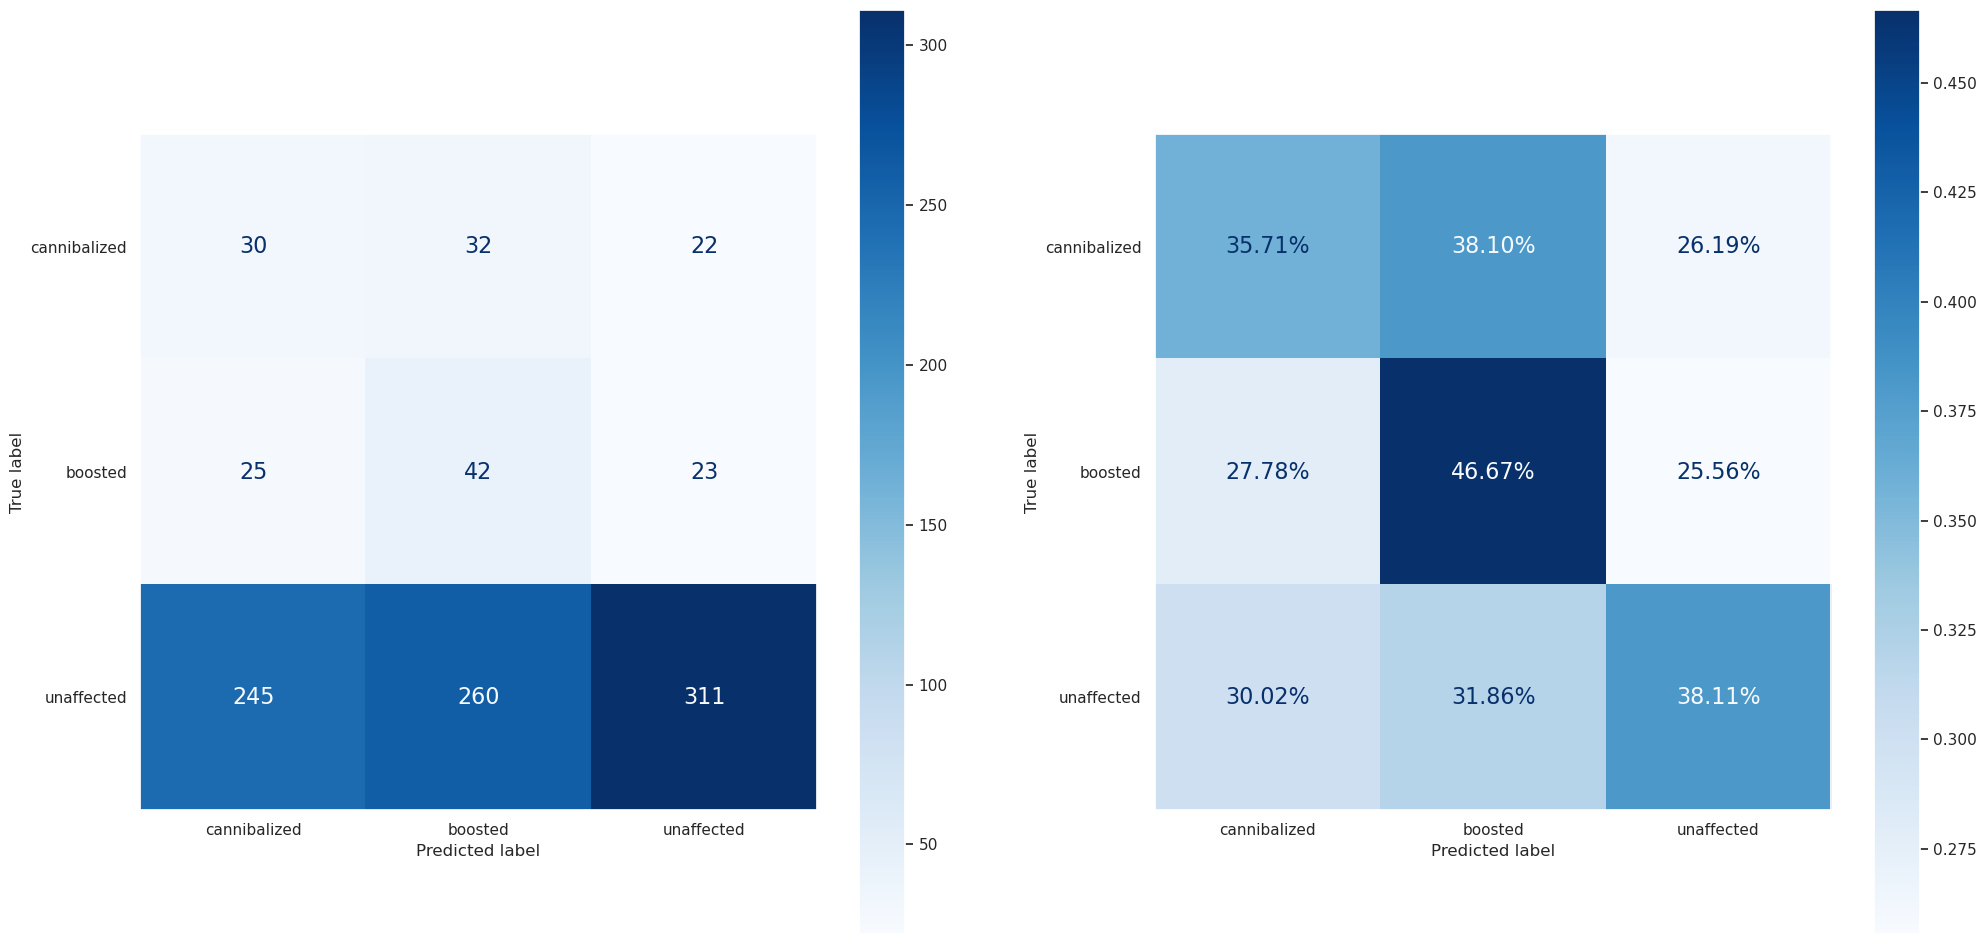

In [78]:
test_baseline_model_with_best_fold(baseline_val_Kfold_report, feat_test_all_fold_preds)

In [79]:
check_fold_train_distribution(pct_constrain=pct_constrain)

boosted         58
cannibalized    46
unaffected      54
Name: prediction, dtype: int64

boosted         56
cannibalized    52
unaffected      50
Name: prediction, dtype: int64

boosted         47
cannibalized    55
unaffected      56
Name: prediction, dtype: int64

boosted         52
cannibalized    50
unaffected      56
Name: prediction, dtype: int64

boosted         52
cannibalized    53
unaffected      53
Name: prediction, dtype: int64

# Constrained Prior Probabilistic Model (CPPM)
The idea is the same to PPM except that we impose a constraint to the distribution of the labels.<br>
Specifically, it constrains the percentage of “cannibalizing” and “boosting” channels to a small fixed pre-determined proportion, __alpha__.<br>
For example, we can constrain __alpha__ to 0.1 or 0.05.

## CPPM (10%-10%-80%)

In [80]:
pct_constrain = True

In [82]:
feat_val_fold_reports, feat_test_fold_reports, feat_test_all_fold_preds, feat_val_Kfold_preds_dists, feat_test_Kfold_preds_dists = baseline_cross_validation(available_feat_videos,
                                                                                                    index_tuples,
                                                                                                    pct_constrain=pct_constrain)

In [83]:
baseline_val_Kfold_report = get_Kfold_report(feat_val_fold_reports)
baseline_test_Kfold_report = get_Kfold_report(feat_test_fold_reports)
plot_Kfold_report(baseline_val_Kfold_report, "Validation (Each fold has different val data):")
plot_Kfold_report(baseline_test_Kfold_report, "Testing (Each fold has the same test data):") # The difference arises from the different slices of training data given to the "model"

plot_Kfold_report(feat_val_Kfold_preds_dists, f"Prediction Distribution on Val (Baseline: constraint={pct_constrain})", background_color="yellow", bold=True)
plot_Kfold_report(feat_test_Kfold_preds_dists, f"Prediction Distribution on Test (Baseline: constraint={pct_constrain})", background_color="yellow", bold=True)

cannibalized                     boosted                       unaffected  \
    precision    recall    f1-score  precision recall    f1-score  precision    
1    0.120253     0.223529  0.156379  0.065844  0.175824  0.095808  0.811352    
2    0.089286     0.235294  0.129450  0.088710  0.241758  0.129794  0.829545    
3    0.107784     0.211765  0.142857  0.127854  0.307692  0.180645  0.828990    
4    0.096552     0.164706  0.121739  0.097872  0.252747  0.141104  0.820968    
5    0.110526     0.247059  0.152727  0.106383  0.219780  0.143369  0.819936    
avg  0.104880     0.216471  0.140630  0.097332  0.239560  0.138144  0.822158    

                        macro avg                     weighted avg          \
    recall    f1-score  precision recall    f1-score  precision    recall    
1    0.589806  0.683064  0.332483  0.329720  0.311750  0.684768     0.5210   
2    0.531553  0.647929  0.335847  0.336202  0.302391  0.699207     0.4800   
3    0.617718  0.707928  0.354876  0.379058  0.343810  0.703884     0.5550   
4    0.617718  0.704986  0.338464  0.345057  0.322610  0.693591     0.5460   
5    0.618932  0.705394  0.345615  0.361924  0.333830  0.694703     0.5510   
avg  0.595146  0.689860  0.341457  0.350392  0.322878  0.695230     0.5306   

               
    f1-score   
1    0.584855  
2    0.556708  
3    0.611914  
4    0.604097  
5    0.607273  
avg  0.592969

cannibalized                     boosted                       unaffected  \
    precision    recall    f1-score  precision recall    f1-score  precision    
1    0.078652     0.166667  0.106870  0.095618  0.266667  0.140762  0.836007    
2    0.086538     0.214286  0.123288  0.121339  0.322222  0.176292  0.837937    
3    0.087719     0.178571  0.117647  0.115385  0.266667  0.161074  0.836334    
4    0.100671     0.178571  0.128755  0.124481  0.333333  0.181269  0.843333    
5    0.091371     0.214286  0.128114  0.134615  0.311111  0.187919  0.841026    
avg  0.088990     0.190476  0.120935  0.118288  0.300000  0.169463  0.838927    

                        macro avg                     weighted avg            \
    recall    f1-score  precision recall    f1-score  precision    recall      
1    0.574755  0.681191  0.336759  0.336029  0.309608  0.704439     0.512121   
2    0.557598  0.669610  0.348605  0.364702  0.323063  0.709037     0.507071   
3    0.626225  0.716188  0.346479  0.357155  0.331636  0.707274     0.555556   
4    0.620098  0.714689  0.356162  0.377334  0.341571  0.714969     0.556566   
5    0.602941  0.702355  0.355671  0.376113  0.339463  0.713199     0.543434   
avg  0.596324  0.696807  0.348735  0.362267  0.329068  0.709784     0.534949   

               
    f1-score   
1    0.583331  
2    0.578408  
3    0.614938  
4    0.616481  
5    0.606865  
avg  0.600005

,unaffected,boosted,cannibalized,unaffected%,boosted%,cannibalized%
1,599.0,243.0,158.0,0.5990,0.2430,0.1580
2,528.0,248.0,224.0,0.5280,0.2480,0.2240
3,614.0,219.0,167.0,0.6140,0.2190,0.1670
4,620.0,235.0,145.0,0.6200,0.2350,0.1450
5,622.0,188.0,190.0,0.6220,0.1880,0.1900
total,2983.0,1133.0,884.0,0.5966,0.2266,0.1768


,unaffected,boosted,cannibalized,unaffected%,boosted%,cannibalized%
1,561.0,251.0,178.0,0.566667,0.253535,0.179798
2,543.0,239.0,208.0,0.548485,0.241414,0.210101
3,611.0,208.0,171.0,0.617172,0.210101,0.172727
4,600.0,241.0,149.0,0.606061,0.243434,0.150505
5,585.0,208.0,197.0,0.590909,0.210101,0.198990
total,2900.0,1147.0,903.0,0.585859,0.231717,0.182424


              precision    recall  f1-score   support

     boosted       0.12      0.27      0.16        90
cannibalized       0.09      0.18      0.12        84
  unaffected       0.84      0.63      0.72       816

    accuracy                           0.56       990
   macro avg       0.35      0.36      0.33       990
weighted avg       0.71      0.56      0.61       990



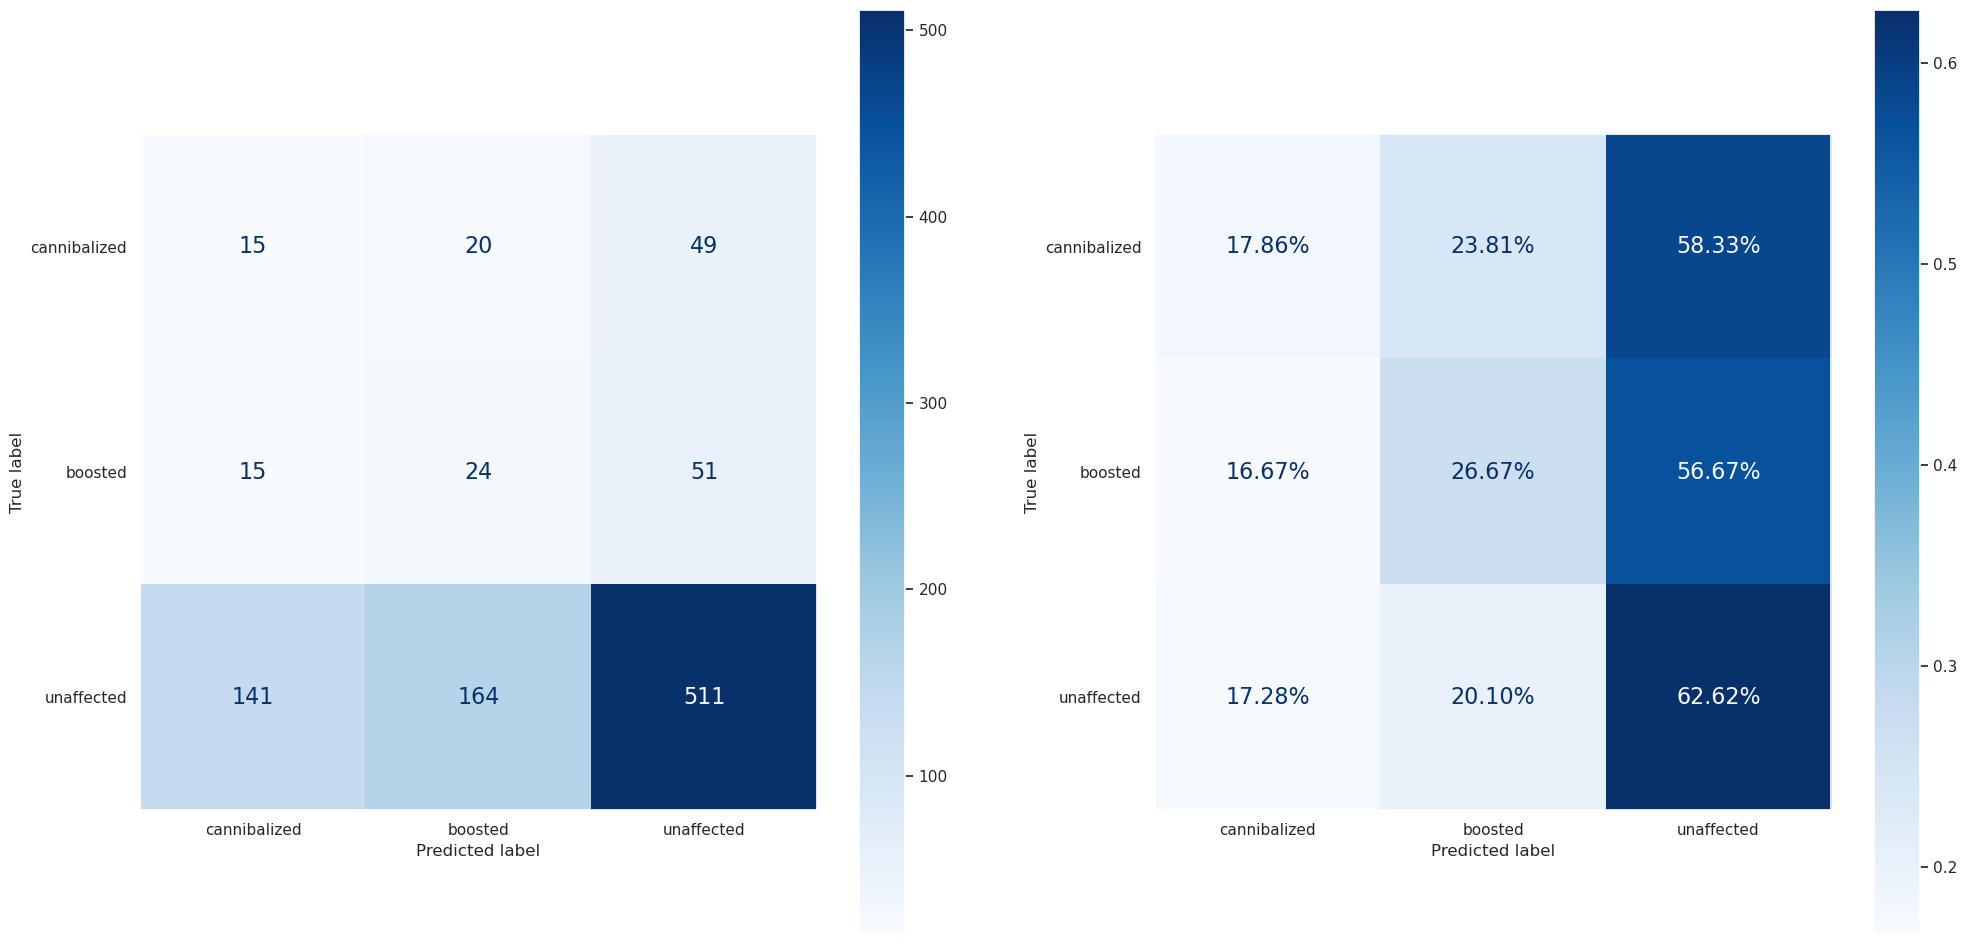

In [84]:
test_baseline_model_with_best_fold(baseline_val_Kfold_report, feat_test_all_fold_preds)

In [85]:
check_fold_train_distribution(pct_constrain=pct_constrain)

boosted          16
cannibalized     16
unaffected      126
Name: prediction, dtype: int64

boosted          16
cannibalized     16
unaffected      126
Name: prediction, dtype: int64

boosted          16
cannibalized     16
unaffected      126
Name: prediction, dtype: int64

boosted          16
cannibalized     16
unaffected      126
Name: prediction, dtype: int64

boosted          16
cannibalized     16
unaffected      126
Name: prediction, dtype: int64

## CPPM (5%-5%-90%)

In [86]:
pct_constrain = True
minority_pct = 0.05

In [87]:
feat_val_fold_reports, feat_test_fold_reports, feat_test_all_fold_preds,  feat_val_Kfold_preds_dists, feat_test_Kfold_preds_dists = baseline_cross_validation(available_feat_videos,
                                                                                                    index_tuples,
                                                                                                    pct_constrain=pct_constrain,
                                                                                                    minority_pct=minority_pct)

In [88]:
baseline_val_Kfold_report = get_Kfold_report(feat_val_fold_reports)
baseline_test_Kfold_report = get_Kfold_report(feat_test_fold_reports)
plot_Kfold_report(baseline_val_Kfold_report, "Validation (Each fold has different val data):")
plot_Kfold_report(baseline_test_Kfold_report, "Testing (Each fold has the same test data):") # The difference arises from the different slices of training data given to the "model"

plot_Kfold_report(feat_val_Kfold_preds_dists, f"Prediction Distribution on Val (Baseline: constraint={pct_constrain})", background_color="yellow", bold=True)
plot_Kfold_report(feat_test_Kfold_preds_dists, f"Prediction Distribution on Test (Baseline: constraint={pct_constrain})", background_color="yellow", bold=True)

cannibalized                     boosted                       unaffected  \
    precision    recall    f1-score  precision recall    f1-score  precision    
1    0.131579     0.176471  0.150754  0.065089  0.120879  0.084615  0.815900    
2    0.076923     0.129412  0.096491  0.090361  0.164835  0.116732  0.811867    
3    0.087379     0.105882  0.095745  0.137931  0.219780  0.169492  0.824468    
4    0.047059     0.047059  0.047059  0.094488  0.131868  0.110092  0.817259    
5    0.086957     0.117647  0.100000  0.096491  0.120879  0.107317  0.815824    
avg  0.085979     0.115294  0.098010  0.096872  0.151648  0.117649  0.817063    

                        macro avg                     weighted avg          \
    recall    f1-score  precision recall    f1-score  precision    recall    
1    0.709951  0.759247  0.337522  0.335767  0.331539  0.689409     0.6110   
2    0.680825  0.740594  0.326384  0.325024  0.317939  0.683740     0.5870   
3    0.752427  0.786802  0.349926  0.359363  0.350679  0.699341     0.6490   
4    0.781553  0.799007  0.319602  0.320160  0.318719  0.686020     0.6600   
5    0.763350  0.788715  0.333090  0.333959  0.332011  0.688411     0.6500   
avg  0.737621  0.774873  0.333305  0.334855  0.330177  0.689384     0.6314   

               
    f1-score   
1    0.646134  
2    0.629074  
3    0.671887  
4    0.672400  
5    0.668167  
avg  0.657532

cannibalized                     boosted                       unaffected  \
    precision    recall    f1-score  precision recall    f1-score  precision    
1    0.076923     0.107143  0.089552  0.075949  0.133333  0.096774  0.823776    
2    0.085714     0.142857  0.107143  0.085106  0.133333  0.103896  0.823695    
3    0.068627     0.083333  0.075269  0.088235  0.133333  0.106195  0.824468    
4    0.084337     0.083333  0.083832  0.073171  0.100000  0.084507  0.820153    
5    0.072993     0.119048  0.090498  0.084034  0.111111  0.095694  0.818801    
avg  0.077719     0.107143  0.089259  0.081299  0.122222  0.097413  0.822179    

                        macro avg                     weighted avg            \
    recall    f1-score  precision recall    f1-score  precision    recall      
1    0.721814  0.769432  0.325550  0.320763  0.318586  0.692423     0.616162   
2    0.715686  0.765902  0.331505  0.330626  0.325647  0.693934     0.614141   
3    0.759804  0.790816  0.327110  0.325490  0.324093  0.693406     0.645455   
4    0.787990  0.803750  0.325887  0.323775  0.324030  0.689813     0.665657   
5    0.736520  0.775484  0.325276  0.322226  0.320558  0.688723     0.627273   
avg  0.744363  0.781077  0.327066  0.324576  0.322583  0.691660     0.633737   

               
    f1-score   
1    0.650594  
2    0.649825  
3    0.667865  
4    0.677280  
5    0.655565  
avg  0.660226

,unaffected,boosted,cannibalized,unaffected%,boosted%,cannibalized%
1,717.0,169.0,114.0,0.7170,0.1690,0.114
2,691.0,166.0,143.0,0.6910,0.1660,0.143
3,752.0,145.0,103.0,0.7520,0.1450,0.103
4,788.0,127.0,85.0,0.7880,0.1270,0.085
5,771.0,114.0,115.0,0.7710,0.1140,0.115
total,3719.0,721.0,560.0,0.7438,0.1442,0.112


,unaffected,boosted,cannibalized,unaffected%,boosted%,cannibalized%
1,715.0,158.0,117.0,0.722222,0.159596,0.118182
2,709.0,141.0,140.0,0.716162,0.142424,0.141414
3,752.0,136.0,102.0,0.759596,0.137374,0.103030
4,784.0,123.0,83.0,0.791919,0.124242,0.083838
5,734.0,119.0,137.0,0.741414,0.120202,0.138384
total,3694.0,677.0,579.0,0.746263,0.136768,0.116970


              precision    recall  f1-score   support

     boosted       0.09      0.13      0.11        90
cannibalized       0.07      0.08      0.08        84
  unaffected       0.82      0.76      0.79       816

    accuracy                           0.65       990
   macro avg       0.33      0.33      0.32       990
weighted avg       0.69      0.65      0.67       990



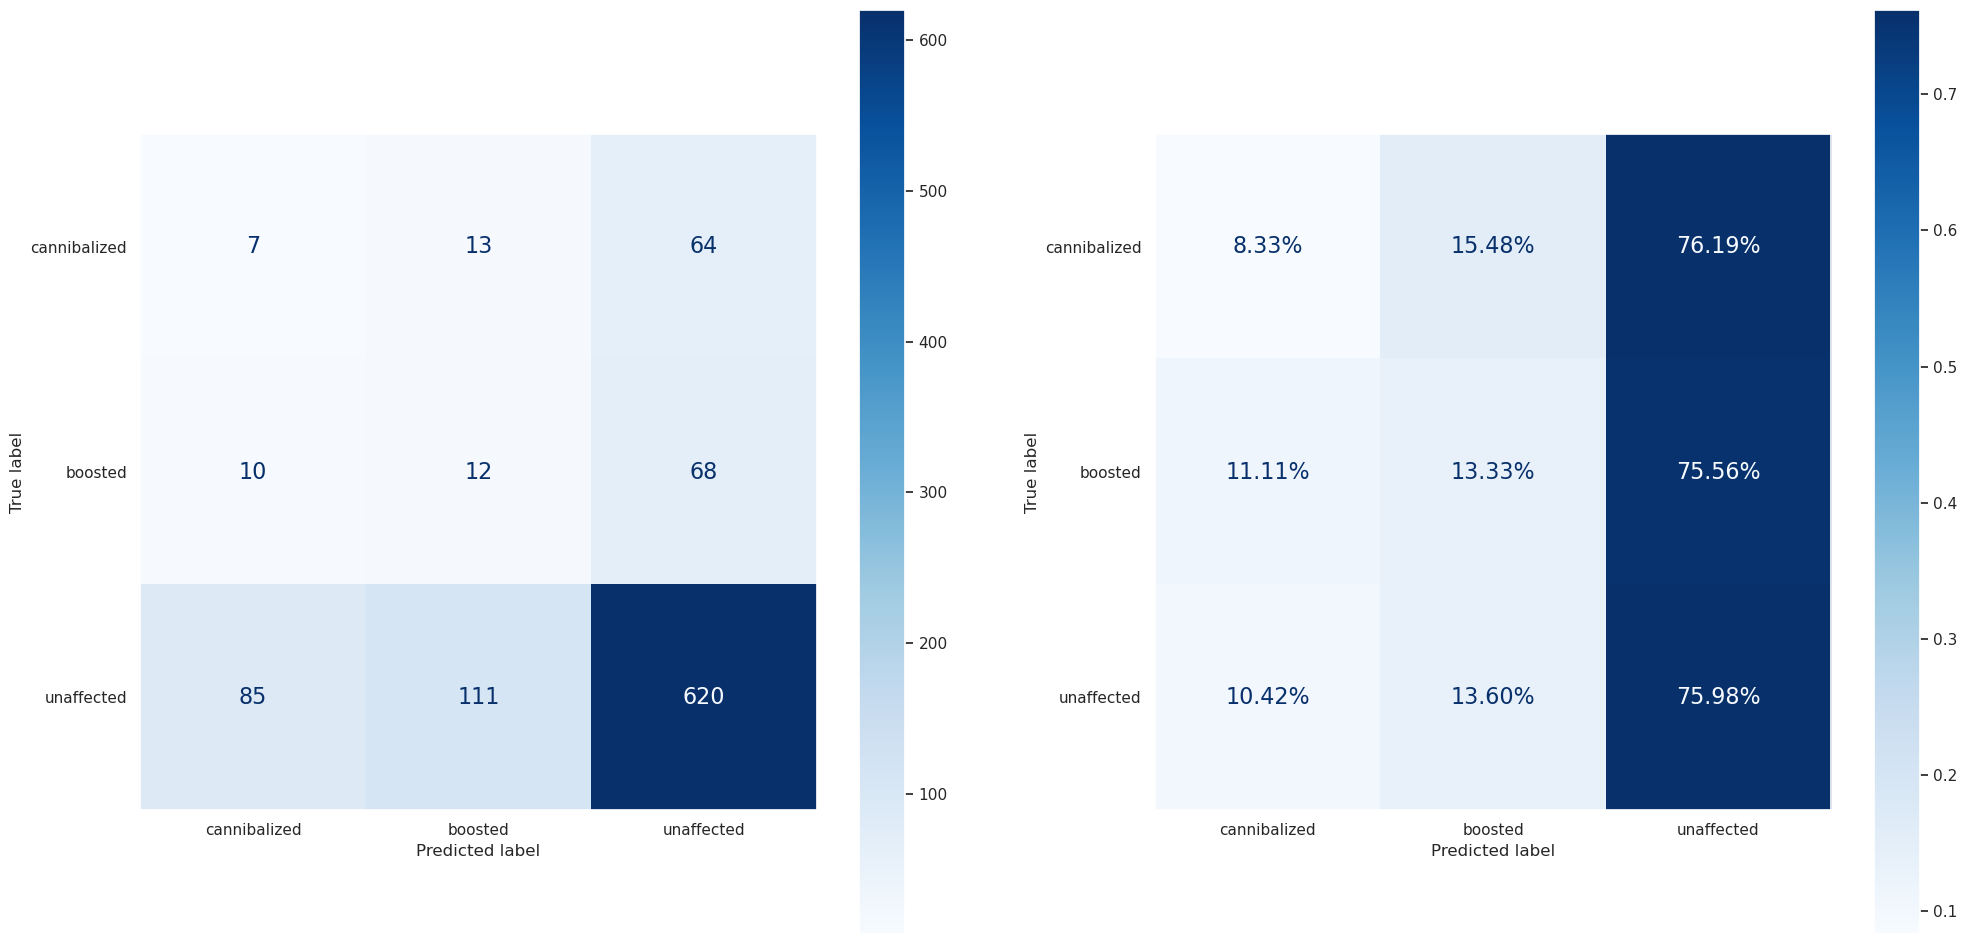

In [89]:
test_baseline_model_with_best_fold(baseline_val_Kfold_report, feat_test_all_fold_preds)

In [90]:
check_fold_train_distribution(pct_constrain=pct_constrain, minority_pct=0.05)

boosted           8
cannibalized      8
unaffected      142
Name: prediction, dtype: int64

boosted           8
cannibalized      8
unaffected      142
Name: prediction, dtype: int64

boosted           8
cannibalized      8
unaffected      142
Name: prediction, dtype: int64

boosted           8
cannibalized      8
unaffected      142
Name: prediction, dtype: int64

boosted           8
cannibalized      8
unaffected      142
Name: prediction, dtype: int64